<a href="https://colab.research.google.com/github/DaeSeokSong/LSTM-PPoA/blob/main/Predict_Price_of_Agricultural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 참조문헌
## [A Prediction Model for Agricultural Products Price with LSTM Network](https://www.koreascience.or.kr/article/JAKO201809469053682.page)

**신성호, 이미경, 송사광**

한국과학기술정보연구원 연구데이터플랫폼센터,
한국과학기술정보연구원 연구데이터플랫폼센터/과학기술연합대학원대학교 빅데이터과학과

Sungho Shin(maximus74@kisti.re.kr), Mikyoung Lee(jerryis@kisti.re.kr),
Sa-kwang Song(esmallj@kisti.re.kr)


---
---



# 당년 농산물 가격 예측 LSTM 모델

Input = 1~저번 달까지의 pram 값을 하나로 묶은 array(인스턴스)

output = 당월의 해당 채소 가격

layer = 원래 해당 채소 가격

### Google Drive Mount

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Models/Legacy System/PPoA
!ls -al

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Models/Legacy System/PPoA
total 822
drwx------ 2 root root   4096 Nov 24  2021  Dataset
-rw------- 1 root root 695680 Nov 29  2021  PPoA_onion.h5
-rw------- 1 root root 141608 Nov  1 16:34 'Predict Price of Agricultural.ipynb'


#### GPU 확인인

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


### Import


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import metrics, losses
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.models import Sequential, load_model
from keras.layers import LSTM, Bidirectional, Dropout, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### Global Variable

In [6]:
TARGET_YEAR = 2020
START_YEAR = 2006
END_YEAR = 2019
CROPS = 'onion'

### Function

##### Data Read/Preprocessing

In [7]:
def ReadDataset(start_year, end_year, last_prams, cur_prams) :
    # 지난 최대 5년간 최대, 최소치를 기준으로 정규화해야 하는 항목들
    df = pd.read_csv('./Dataset/'+CROPS+'/last_production_'+CROPS+'.csv', index_col=0, encoding='cp949')
    # 전년 재배면적
    last_cultiv_area = df['전년면적']
    last_prams.append(last_cultiv_area)
    # 전년 평균 생산단수
    last_prod_unit = df['전년단수']
    last_prams.append(last_prod_unit)
    # 전년 평균 생산량(수확량)
    last_production = df['전년생산량']
    last_prams.append(last_production)

    for next in range(0, (end_year-start_year)+1) :
        cur_year = start_year + next

        f_name = str(cur_year)+'_'+CROPS+'.csv'
        df = pd.read_csv('./Dataset/'+CROPS+'/'+f_name, index_col=0)

        ''' 기상변수 '''
        # 강수량
        precipi_avg = df['평균월강수량(mm)']
        precipi_max = df['최다월강수량(mm)']
        # 기온
        temper_avg = df['평균기온(℃)']
        temper_max = df['평균최고기온(℃)']
        temper_min = df['평균최저기온(℃)']
        # 풍속
        windSpeed_avg = df['평균풍속(m/s)']
        windSpeed_max = df['최대풍속(m/s)']
        # 습도
        humidity_avg = df['평균습도(%rh)']
        humidity_min = df['최저습도(%rh)']
        # 일조량 / 일사량
        sunshine = df['일조합']
        insolation = df['일사합']

        ''' 기타변수 '''
        # 전년 수입량
        last_amount_import = df['전년수입량']
        # 해당 농작물 가격 (index == 12)
        crops_price = df['가격']
        # 경유 가격
        diesel_price = df['경유가격']
        # 물가지수(price index -> pidx), 2015년 기준 얼마나 오르고 내렸는지
        total_pidx = df['총물가지수']
        prod_pidx = df['상품']
        agricul_marine_prod_pidx = df['농축수산물']
        indust_prod_pidx = df['공업제품']
        serv_pidx = df['서비스']
        pub_serv_pidx = df['공공서비스']
        per_serv_pidx = df['개인서비스']
        house_pidx = df['집세']

        # 정규화 해야하는 데이터셋
        prams = [precipi_avg, precipi_max,             # 강수량
                temper_avg, temper_max, temper_min,    # 기온
                windSpeed_avg, windSpeed_max,          # 풍속
                humidity_avg, humidity_min,            # 습도
                sunshine,                              # 일조량
                insolation,                            # 일사량
                crops_price,                           # 해당 농작물 월별 가격
                diesel_price,                          # 월별 경유 가격
                last_amount_import,                    # 전년 수입량
                # 물가지수
                total_pidx, prod_pidx, agricul_marine_prod_pidx, indust_prod_pidx, serv_pidx, pub_serv_pidx, per_serv_pidx, house_pidx,
                ]

        cur_prams.append(prams)

def ArrangeDataset(X_dataset, y_dataset, norm_last, norm_cur) :
    # X, y 데이터셋 구분
    for cur, year in enumerate(norm_cur) :
        tmp_X1 = [[], [], [], [], []] # 1~5월
        tmp_y1 = [] # 6월
        tmp_X2 = [[], [], [], [] ,[]] # 7~11월
        tmp_y2 = [] # 12월
        for idx, data in enumerate(year) :
            for month in range(0, 12) :
                if idx == 11 : 
                    if month == 5 : tmp_y1.append(data[month])
                    elif month == 11: tmp_y2.append(data[month])
                else :
                    if month < 5 : tmp_X1[month].append(data[month])
                    elif month > 5 and month < 11 : tmp_X2[month-6].append(data[month])

        for last_data in norm_last :
            for month in tmp_X1 : month.append(last_data[cur])
            for month in tmp_X2 : month.append(last_data[cur])
        
        X_dataset.append(tmp_X1)
        y_dataset.append(tmp_y1)
        X_dataset.append(tmp_X2)
        y_dataset.append(tmp_y2)

    # 데이터 형변환
    X_dataset = np.array(X_dataset)
    y_dataset = np.array(y_dataset)

    # reshape X_dataset
    X_dataset = X_dataset.reshape(X_dataset.shape[0], X_dataset.shape[1] * X_dataset.shape[2], 1)

    return X_dataset, y_dataset

##### Nomalization

In [8]:
# 정규화
def Normalization(targetData) :
    return (targetData - targetData.min()) / (targetData.max() - targetData.min() + 1e-7) # 1e-7은 0으로 나누는 오류 예방차원

def Normalize(start_year, end_year, last_prams, cur_prams, is_pred=False) :
    # last_prams
    norm_last = []
    for idx, pram in enumerate(last_prams) :
        tmp_last = []
        for next in range(0, (end_year-start_year)+1) :
            tmp_df = pram

            cur_year = start_year + next
            year_list = tmp_df.index.values.tolist()
            if cur_year-4 < year_list[-1] : year_list = year_list[year_list.index(cur_year):len(year_list)] # 5년간 데이터가 없을 경우
            else : year_list = year_list[year_list.index(cur_year):year_list.index(cur_year-4)+1]           # 5년간 데이터가 있는 경우

            tmp_df = tmp_df.loc[year_list]
            tmp_last.append(Normalization(tmp_df).to_numpy()[0])
        norm_last.append(tmp_last)

    # prams
    for idx, data in enumerate(cur_prams) :
        for i, pram in enumerate(data) :
            if is_pred and i == 11 : continue

            pram = Normalization(pram)
            pram = pram.to_numpy()

            cur_prams[idx][i] = pram

    return norm_last, cur_prams

# 정규화하기 이전의 org_x값과 되돌리고 싶은 x를 입력하면 역정규화된 값을 리턴한다
def Denormalization_min(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)

    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()
def Denormalization_max(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)

    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.max()
def Denormalization_avg(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)

    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + ((org_x_np.min() + org_x_np.max()) / 2)

### Data read

In [9]:
# Read train dataset
cur_prams = []
last_prams = []
ReadDataset(START_YEAR, END_YEAR, last_prams, cur_prams)

# Read predicted dataset
pred_cur_prams = []
pred_last_prams = []
ReadDataset(TARGET_YEAR, TARGET_YEAR, pred_last_prams, pred_cur_prams)

### Data preprocessing

In [10]:
# Arrange train dataset
X_dataset = []
y_dataset = []
last_prams, cur_prams = Normalize(START_YEAR, END_YEAR, last_prams, cur_prams)
X_dataset, y_dataset = ArrangeDataset(X_dataset, y_dataset, last_prams, cur_prams)

# Arrange predicted dataset
pred_X_dataset = []
pred_y_dataset = []
pred_last_prams, pred_cur_prams = Normalize(TARGET_YEAR, TARGET_YEAR, pred_last_prams, pred_cur_prams, is_pred=True)
pred_X_dataset, pred_y_dataset = ArrangeDataset(pred_X_dataset, pred_y_dataset, pred_last_prams, pred_cur_prams)

### Data split

In [12]:
# Data division (Train : Test = 8 : 2)
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size = 0.2)
print("########## Train + Test (X,) (y,) / Test (X,) (y,) ##########")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Data division (Train : Validation = 8 : 2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)
print("########## Train (X,) (y,) / Validation (X,) (y,) ##########")
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

########## Train + Test (X,) (y,) / Test (X,) (y,) ##########
(22, 120, 1) (22, 1) (6, 120, 1) (6, 1)
########## Train (X,) (y,) / Validation (X,) (y,) ##########
(17, 120, 1) (17, 1) (5, 120, 1) (5, 1)


### Modeling

In [22]:
with tf.device('/device:GPU:0'):
    model = Sequential()

    model.add(Bidirectional(LSTM(64,                        # 해당 층의 노드 개수
                        input_shape=(17, 120, 1),        # input_shape=?
                        return_sequences=True)))         # return_sequences == 각 시퀀스를 출력할지
    #model.add(Dropout(0.01))                                # 과적합 방지용 Ex. Dropout 20%(==0.2)
    model.add(Bidirectional(LSTM(16)))
    model.add(Dense(1, activation='relu'))

    model.build(input_shape=(17, 120, 1))
    model.compile(loss=losses.MeanSquaredError(),
                optimizer=Adam(learning_rate=0.00005),    # pram ex. learning_rate=0.0001 / original = 0.001
                metrics=[metrics.MeanSquaredError()]
                )

    model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (17, 120, 128)           33792     
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (17, 32)                 18560     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (17, 1)                   33        
                                                                 
Total params: 52,385
Trainable params: 52,385
Non-trainable params: 0
_________________________________________________________________


### Learning

Epoch 1/500
2/2 [==============================] - 7s 1s/step - loss: 0.1187 - mean_squared_error: 0.1187 - val_loss: 0.3761 - val_mean_squared_error: 0.3761
Epoch 2/500
2/2 [==============================] - 0s 60ms/step - loss: 0.1149 - mean_squared_error: 0.1149 - val_loss: 0.3660 - val_mean_squared_error: 0.3660
Epoch 3/500
2/2 [==============================] - 0s 59ms/step - loss: 0.1108 - mean_squared_error: 0.1108 - val_loss: 0.3562 - val_mean_squared_error: 0.3562
Epoch 4/500
2/2 [==============================] - 0s 71ms/step - loss: 0.1075 - mean_squared_error: 0.1075 - val_loss: 0.3465 - val_mean_squared_error: 0.3465
Epoch 5/500
2/2 [==============================] - 0s 70ms/step - loss: 0.1037 - mean_squared_error: 0.1037 - val_loss: 0.3372 - val_mean_squared_error: 0.3372
Epoch 6/500
2/2 [==============================] - 0s 66ms/step - loss: 0.1003 - mean_squared_error: 0.1003 - val_loss: 0.3280 - val_mean_squared_error: 0.3280
Epoch 7/500
2/2 [=========================

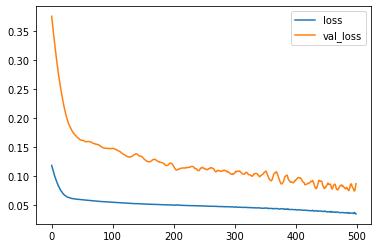

In [23]:
    history = model.fit(X_train, y_train,
                        validation_data = (X_val, y_val),
                        batch_size = 10,                    # Train set's 1~2%, current = 1~2%
                        epochs = 500,                       # Train set's 10%, current = 20%
                        verbose = 1,                        # 0=silent, 1=progress bar, 2=one line per epoch.
                        )

    # loss and acc graph (train nd val)
    history_df = pd.DataFrame(history.history)
    history_df[["loss", "val_loss"]].plot()

    # Acc and Loss about real data
    learning_loss, _ = model.evaluate(X_test, y_test, verbose=2)
    y_pred = model.predict(pred_X_dataset)

    print("Learning loss(MSE) % :", learning_loss * 100)
    print("Learning accuracy(MSE) % :", 100 - (learning_loss * 100))
    #print("Learning loss(RMSE) % :", np.sqrt(mean_squared_error(y_test, y_pred)) * 100)
    #print("Learning accuracy(RMSE) % :", 100 - (np.sqrt(mean_squared_error(y_test, y_pred)) * 100))

### Load model

In [ ]:
#model = load_model('PPoA_onion.h5')

### Prediction

In [ ]:
"""
pred_min_price = Denormalization_min(ori_prices, pred_res)
for idx, price in enumerate(pred_min_price) : pred_min_price[idx] = round(price[0])
pred_max_price = Denormalization_max(ori_prices, pred_res)
for idx, price in enumerate(pred_max_price) : pred_max_price[idx] = round(price[0])
pred_avg_price = Denormalization_avg(ori_prices, pred_res)
for idx, price in enumerate(pred_avg_price) : pred_avg_price[idx] = round(price[0])
    
price_June = {}
price_Dec = {}
for idx in range(0, 2) :
    min = pred_min_price[idx].astype(int)[0]
    avg = pred_avg_price[idx].astype(int)[0]
    max = pred_max_price[idx].astype(int)[0]
    if idx == 0 :
        price_June['최저가'] = min
        price_June['평균가'] = avg
        price_June['최고가'] = max
    else :
        price_Dec['최저가'] = min
        price_Dec['평균가'] = avg
        price_Dec['최고가'] = max

for scale, price in price_June.items() :
    print("6월달 예상 "+ scale +" = ", price)
print('----------------------------')
for scale, price in price_Dec.items() :
    print("12월달 예상 "+ scale +" = ", price)
print('----------------------------')
for idx, price in enumerate(pred_y_dataset.tolist()) :
    if idx == 0 : print("실제 6월 양파 가격 = ", price[0])
    else : print("실제 12월 양파 가격 = ", price[0])
"""

6월달 예상 최저가 =  686
6월달 예상 평균가 =  1014
6월달 예상 최고가 =  1342
----------------------------
12월달 예상 최저가 =  881
12월달 예상 평균가 =  1209
12월달 예상 최고가 =  1537
----------------------------
실제 6월 양파 가격 =  569
실제 12월 양파 가격 =  1225


### Model save

In [ ]:
#model.save('PPoA_onion.h5')